# Pitch Determination Code
 
 

In [1]:
# General useful imports
import array as ar
import contextlib
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio
import scipy.io.wavfile as wf

from numpy import arange,linspace,mean, var, std, corrcoef, cov, transpose, ones,log,pi, sin, cos, exp, abs, angle, convolve
from numpy.random import random, randint, uniform
from scipy import signal
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlab

from math import sqrt

%matplotlib inline

# Basic parameters for reading and writing mono wave files

numChannels   = 1                      # mono
sampleWidth   = 2                      # in bytes, a 16-bit short
SR            = 44100                  #  sample rate
MAX_AMP       = (2**(8*sampleWidth - 1) - 1)    #maximum amplitude is 2**15 - 1  = 32767
MIN_AMP       = -(2**(8*sampleWidth - 1))       #min amp is -2**15
windowWidth   = 4410
windowSlide   = 2205


def round4(x):
    return np.around(x,4)

def round2(x):
    return np.around(x,2)

# Basic Numpy statistical functions

X = np.array([1,2,3])       # just an example
Y = np.array([4,5,6])
             
# mean of a list
mean(X)                            

# Clip a signal or a scalar to upper and lower bounds, if not specified, us
# bounds provided above; will change the array in place and return it.
# Does NOT make a new copy. 

def clip(X,lb=MIN_AMP,ub=MAX_AMP):
    
    if type(X) != list and type(X) != np.ndarray:
        return max(min(X,MAX_AMP),MIN_AMP)
    
    for k in range(len(X)):
        X[k] = max(min(X[k],MAX_AMP),MIN_AMP)
    return X

# To prevent clipping, this function takes a signal and rescales the amplitude
# (which must be given in relative units, in range 0 .. 1) so that 
#
#           max(X) = A * MAX_AMP
#

def scaleSignal(X,A=1.0):
        s = MAX_AMP*A/max(X)
        return np.array( [ x*s for x in X ] ).astype(int)

    
# create a signal from a spectrum represented as triples (freq,amp,phase)
# mode = 'absolute' (amplitude in spectrum is in range MIN_AMP .. MAX_AMP)
#      = 'relative' (amplitude in spectrum is in range 0 .. 1)
# if amp != None, will be resca

def makeSignal(S=[(220,1,0)], mode = 'relative', amp=None, duration=1):
    X = np.zeros(int(SR*duration)) 
    T = np.arange(int(SR*duration))
    if mode == 'relative':
        for (f,A,phi) in S:         
            X += MAX_AMP * A * np.sin( 2 * pi * f * T / SR + phi ) 
    else: # mode == 'relative'
        for (f,A,phi) in S:         
            X +=  A * np.sin( 2 * pi * f * T / SR + phi ) 
    if amp == None:
        return X.astype(int) 
    else:
        return (((X * MAX_AMP)/ max(X)) * amp).astype(int) 

# Some sample spectra
    
def makeSpectrum(instr,freq=220):
    if(instr=="triangle"):
        return ([(freq,1.0,0.0),    
        (freq*3,-1/(9),0.0), 
        (freq*5,1/(25),0.0), 
        (freq*7,-1/(49),0.0), 
        (freq*9,1/(81),0.0), 
        (freq*11,-1/(121),0.0), 
        (freq*13,1/(13*13),0.0)])
    elif(instr=="square"):
        return ([(freq,2/(np.pi),0.0), 
        (freq*3,2/(3*np.pi),0.0), 
        (freq*5,2/(5*np.pi),0.0), 
        (freq*7,2/(7*np.pi),0.0), 
        (freq*9,2/(9*np.pi),0.0), 
        (freq*11,2/(11*np.pi),0.0), 
        (freq*13,2/(13*np.pi),0.0),
        (freq*15,2/(15*np.pi),0.0),
        (freq*17,2/(17*np.pi),0.0),
        (freq*19,2/(19*np.pi),0.0),
        (freq*21,2/(21*np.pi),0.0)])
    elif(instr=="clarinet"):
        return ([(freq,0.314,0.0), 
        (freq*3,.236,0.0), 
        (freq*5,0.157,0.0), 
        (freq*7,0.044,0.0), 
        (freq*9,0.157,0.0), 
        (freq*11,0.038,0.0), 
        (freq*13,0.053,0.0)] ) 
    elif(instr=="bell"):
        return ([(freq,0.1666,0.0), 
        (freq*2,0.1666,0.0), 
        (freq*3,0.1666,0.0), 
        (freq*4.2,0.1666,0.0), 
        (freq*5.4,0.1666,0.0), 
        (freq*6.8,0.1666,0.0)])  
    elif(instr=="steelstring"):
        return ([(freq*0.7272, .00278,0.0),
        (freq, .0598,0.0),
        (freq*2, .2554,0.0),
        (freq*3, .0685,0.0),
        (freq*4, .0029,0.0),
        (freq*5, .0126,0.0),
        (freq*6, .0154,0.0),
        (freq*7, .0066,0.0),
        (freq*8, .0033,0.0),
        (freq*11.0455, .0029,0.0),
        (freq*12.0455, .0094,0.0),
        (freq*13.0455, .0010,0.0),
        (freq*14.0455, .0106,0.0),
        (freq*15.0455, .0038,0.0)])
    elif(instr=='organ'):
        return ([(freq*1, 0.16042589643241895, 0.0),
        (freq*2, 0.1655, 0.0),
        (freq*3, 0.0015, 0.0),
        (freq*3.9949, 0.02161, 0.0),
        (freq*5.9949, 0.04552, 0.0),
        (freq*7.9949, 0.0324, 0.0),
        (freq*9.9899, 0.00242, 0.0),
        (freq*11.9898, 0.0045, 0.0),
        (freq*17.9847, 0.0057, 0.0),
        (freq*19.9796, 0.0011, 0.0),
        (freq*27.9745, 0.0008, 0.0),
        (freq*29.9745, 0.0016, 0.0)]        
        )
    else:
        return []
    
instruments =    ['triangle','square', 'bell', 'organ', 'steelstring', 'clarinet']

# Piano key frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

min_freq = Freqs['A0']
max_freq = Freqs['C8']
min_period = SR/max_freq
max_period = SR/min_freq

print(min_period)
print(max_period)

10.535094293377469
1603.6363636363637


In [2]:
def makeNote(instrument, note="", pitch=0):
    if pitch == 0:
        pitch = Freqs[note]
    S = makeSpectrum(instrument,pitch)
    return makeSignal(S,duration=0.5)
    
X = makeNote('bell',pitch=1000)
Audio(X,rate=SR)

In [3]:
max(X[:100])

24232

In [4]:
# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = ar.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# Write out an array as a wave file to the local directory
        
def writeWaveFile(X,fname):
    X = clip(X)
    params = [1,2, SR , len(X), "NONE", None]
    data = ar.array("h",X)
    with contextlib.closing(wave.open(fname, "w")) as f:
        f.setparams(params)
        f.writeframes(data.tobytes())
    print(fname + " written.")

In [5]:
# Read a stereo wave file from a local file and return the entire file as a 2-D numpy array
# These read or write a stereo file

# Thanks to Elisson for these

def readWaveFileStereo(infile):
    rate, data = wf.read(infile)
    return np.array([data[:,0], data[:,1]])

def writeWaveFileStereo(filename, data, rate=SR, ):
    dataAlt = (data.T).astype(np.int16)
    wf.write(filename, rate, data.T)

In [6]:
# Display a graph of a signal

def displaySignal(X, left = 0, right = -1, minAmp=-1.2, maxAmp=1.2,title='Signal Window for X',signalRelative=False,xUnits = "Seconds", yUnits = "Relative",width=12, height=4):
    
    if(signalRelative):
        X = [x*MAX_AMP for x in X]
    minAmplitude = -(2**15 + 100)        # just to improve visibility of curve
    maxAmplitude = 2**15 + 300    
    
    if(xUnits == "Samples"):
        if(right == -1):
            right = len(X)
        T = range(left,right)
        Y = X[left:right]
    elif(xUnits == "Seconds"):
        if(right == -1):
            right = len(X)/44100
        T = np.arange(left, right, 1/44100)
        leftSampleNum = int(left*44100)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    elif(xUnits == "Milliseconds"):
        if(right == -1):
            right = len(X)/44.1
        T = np.arange(left, right, 1/44.1)
        leftSampleNum = int(left*44.1)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    else:
        print("Illegal value for xUnits")
        
    if(yUnits == "Relative"):
        minAmplitude = minAmp            # just to improve visibility of curve
        maxAmplitude = maxAmp
        Y = [x/32767 for x in Y]

    fig = plt.figure(figsize=(width,height))   # Set x and y dimensions of window: may need to redo for your display
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax = plt.axes()
    if(xUnits=="Samples"):
        ax.set_xlabel("Sample Number")
    else:
        ax.set_xlabel(xUnits)
    ax.set_ylabel(yUnits + ' Amplitude')
    ax.set_ylim([minAmplitude,maxAmplitude])
    ax.set_xlim([left, right])
    plt.axhline(0, color='black')      # draw the 0 line in black
    plt.plot(T,Y) 
    if(    (xUnits == "Samples" and (right - left) < 101)
        or (xUnits == "Seconds" and (right - left) < 0.001)
        or (xUnits == "Milliseconds" and (right - left) < 1) ):
            plt.plot(T,Y, 'ro')                     
    plt.grid(True)                     # if you want dotted grid lines
    plt.show()
    
f = 10
T = np.arange(SR*1)
X = MAX_AMP * np.sin(2*pi*f*T/SR)

# displaySignal(X)


In [7]:
# def plotSignals(signals, titles=[]):
#     print()
#     if titles == []:
#         if len(signals) > 1:
#             titles = ['Signal ' + str(k+1) + '\n' for k in range(len(signals))]
#         else:
#             titles = ['Signal\n']
#     else:
#         titles = [t + '\n' for t in titles]
            
#     number_of_subplots=len(signals)
    
#     N = len(signals[0])

#     fig = plt.figure(figsize=(12,number_of_subplots*4))
#     fig.subplots_adjust(hspace=0.75)
#     #fig.suptitle("Comparison ",fontsize=16)
    
#     for i,v in enumerate(range(number_of_subplots)):
#         v = v+1
#         ax1 = subplot(number_of_subplots,1,v)
        
#         ax1.set_ylabel('Amplitude')
#         ax1.set_xlabel('Time (ms)') 
#         ax1.plot([0,N-1],[0,0],color='black',lw=0.75)
#         ax1.plot([0,0],[-1,1],color='black',lw=0.75)    
#         ax1.set_ylim([-1.2,1.2])
#         plt.xlim([0,N-1])
#         ax1.grid(color='0.75')
#         ax1.plot(signals[i],color='b',lw=1)
#         ax1.set_title(titles[i],fontsize=14)
#     plt.show()

# # Just an example
  
# f = 10
# T = np.arange(SR*1)
# X10 = np.sin(2*pi*f*T/SR)
# X20 = np.sin(2*pi*2*f*T/SR)
# X30 = np.sin(2*pi*3*f*T/SR)
# X40 = np.sin(2*pi*4*f*T/SR)

# plotSignals([X10,X20,X30,X40])

###  Displaying Spectra

Matplotlib has a useful function to display spectra:

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.magnitude_spectrum.html

The term "magnitude spectrum" refers to the fact that we are interested in magnitude
of the various frequencies which make up the signal, instead of the power spectrum (square of the magnitudes) or the phase spectrum (what the phase of the various frequency components are). 



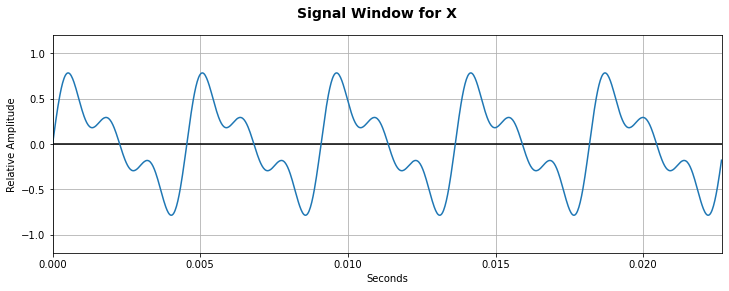

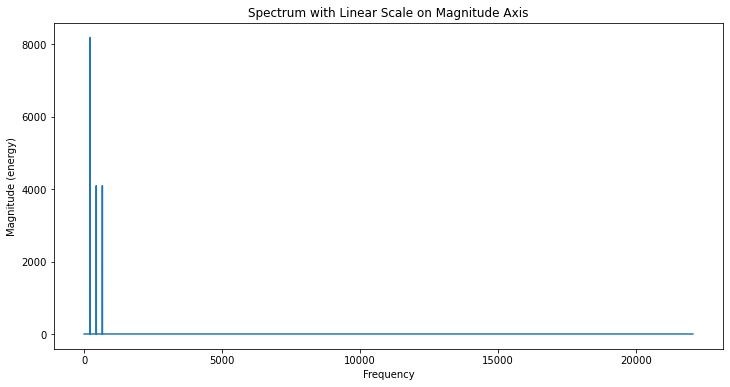

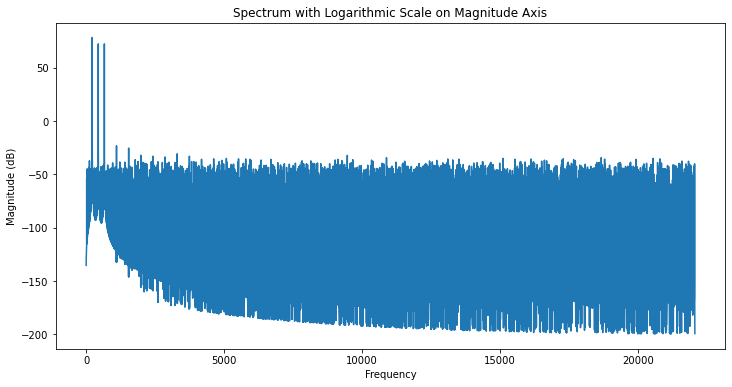

In [8]:
X = makeSignal([(220,0.5,0),(440,0.25,0.0),(660,0.25,0.0)])
displaySignal(X[:1000])

plt.figure(figsize=(12,6))
plt.title("Spectrum with Linear Scale on Magnitude Axis")
plt.magnitude_spectrum(X,SR)
plt.show()

plt.figure(figsize=(12,6))
plt.title("Spectrum with Logarithmic Scale on Magnitude Axis")
plt.magnitude_spectrum(X,SR,scale='dB')
plt.show()

### Calculating Spectra using the Fast-Fourier Transform

0.008346313740791261
0.023372739861330354
0.00911426257459123
22051


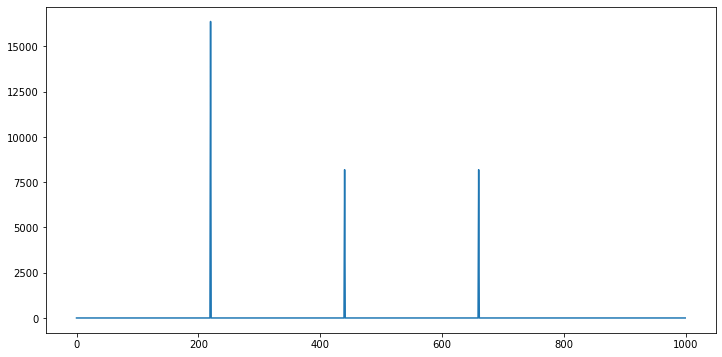

In [9]:

def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X)
       
# return the phase spectrum

def phaseFFT(X):
    return [np.angle(x) for x in np.fft.rfft(X)]
    
# return fft coefficients in polar form

def polarFFT(X):
    return [(abs(2*x/len(X)), np.angle(2*x/len(X))) for x in np.fft.rfft(X)]

# We can also return a list of triples of form  (f, A, phi) for each frequency
# f detected by the transform
    
def spectrumFFT(X):
    R = np.fft.rfft(X)
    return [ ( k*44100/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k]) ) for k in range(len(R)) ]

# S = spectrumFFT(X)
# S[990:1010]

X = makeSignal([(220,0.5,0),(440,0.25,0.0),(660,0.25,0.0)])

S = realFFT(X)

print(S[1000])
print(S[3000])
print(S[5000])

print(len(S))

plt.figure(figsize=(12,6))
plt.plot(S[:1000])
plt.show()

### Displaying Spectrograms

To display spectrograms (spectra over time), we use `specgram`:

https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.specgram.htm

There are a number of parameters of interest:

- `NFFT`  (int)  is the number of data points used in each block for the FFT. A power 2 is most efficient. The default value is 256. 

- `noverlap` (int) is the number of points of overlap between blocks. The default value is 128.

- `mode` can be used to set the values plotted on the amplitude (Y) axis:
   - `magnitude`  is  the amplitude of the sine wave in the signal
   - `psd` is the power, i.e., the amplitude squared
   - The default is `psd`, which corresponds to our human perception of loudness.


- `scale`  determines the scaling on the Y axis, either
   - `linear` or 
   - `dB` for a logarithmic scale in decibels; 
   - `default` is `dB` if `mode` is `psd` or `magnitude`,  and `linear` otherwise. 



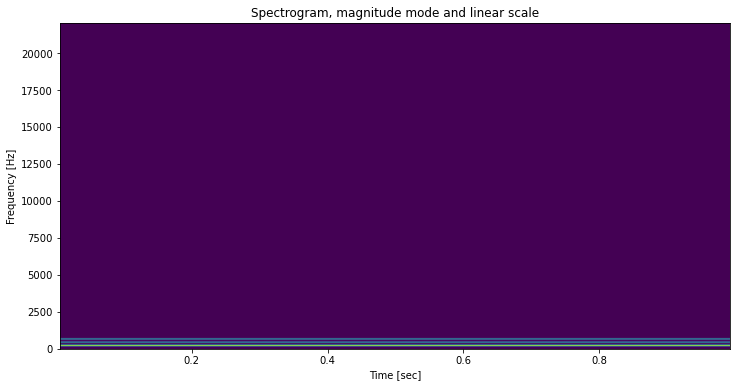

In [10]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram, magnitude mode and linear scale')
plt.specgram(X, NFFT=1024,noverlap=512,Fs=SR,mode='magnitude',scale='linear')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
# Audio(X,rate=SR)

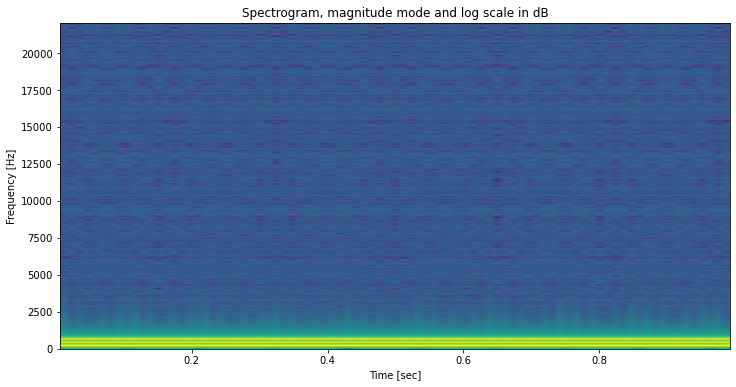

In [11]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram, magnitude mode and log scale in dB')
plt.specgram(X, NFFT=1024,noverlap=512,Fs=SR,mode='magnitude',scale='dB')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

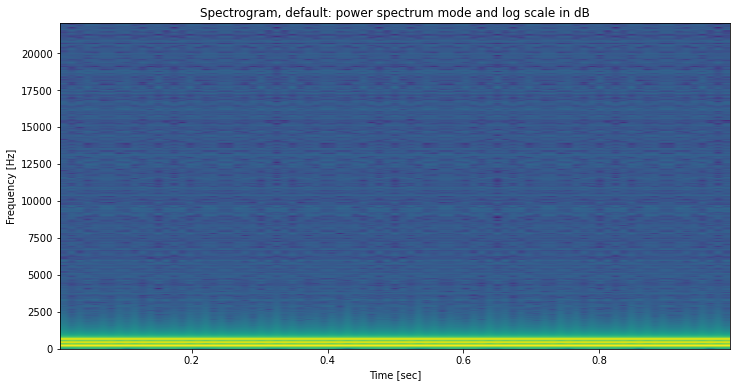

In [12]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram, default: power spectrum mode and log scale in dB')
# plt.specgram(X, NFFT=1024,noverlap=512,Fs=SR,mode='psd',scale='dB')
plt.specgram(X, NFFT=1024,noverlap=512,Fs=SR)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

##  Problem One (Autocorrelation)


### Correlation 

The correlation of two sequences of length $N$ is exactly the same as if we consider them to be equiprobable, finite random variables:

$$corr(X,Y)\,=\, {Cov(X,Y)\over \sigma_X\cdot \sigma_Y} \,
             =\,{E[(X-\mu_X)\cdot (Y-\mu_Y)]\over\sigma_X\cdot \sigma_Y}
             =\,E\left[{X-\mu_X\over\sigma_X} \cdot {Y-\mu_Y\over\sigma_Y}\right]
             \,=\, E[Z_X\cdot Z_Y] \,=\,  {Z_X @ Z_Y\over N}$$

where $@$ represents the dot product of the two standardized signals. 

Since we are looking for the maximum of the correlation, we do not mathematically speaking need
to standardize, however, to prevent arithmetic overflow with large numbers, generallly we need
to normalize the signals.  We may therefore use approximations to the mean and standard deviation,
which for a simple sine wave $X$ are $\mu_X = 0.0$ and $\sigma_X = {1\over \sqrt 2} = 0.707.$

In our context, with wave files, we will use 

$$\sigma_X \, =\,  {\text{MAX_AMP}\over \sqrt 2} \, =\, 3169.7679$$ 


This is about 5x faster than using full standardization and works just as well!


### Part (A)

Complete the following code template to calculate $corr(X,Y)$, where we assume that $X$ and $Y$ are two signals of the same length. 

In [13]:
stdX = MAX_AMP/sqrt(2)


def corr(X,Y,normalize=True):    
    if normalize:
        X = X/stdX
        Y = Y/stdX
    return (X @ Y) / len(X)

# test

X = makeSignal()
X1 = X * 0.34
Y = -1 * X

print(corr(X,X))    # should be close to 1.0
print(corr(X,X1))   # should be close to 0.34
print(corr(X,Y))    # should be close to -1.0
print(corr(X1,Y))   # should be close to -0.34

print(corr(X,X,normalize=False))    # should be close to 536816844.60861677

print(  corr(X,X1,normalize=False) / corr(X,X,normalize=False))    # should be close to 0.34

0.9999603234390074
0.33998650996926255
-0.9999603234390074
-0.33998650996926255
-5371.617052154195
-33978.17182327509


### Autocorrelation

When we correlate a signal with a delayed or lagged version of itself, we have the `autocorrelation` of
a signal. 
 

The *autocorrelation at lag k* of a signal $X$ of length $N$ at lag $k$ (a sample number) is the correlation of `X[:N-k]` with `X[k:]`:

$$acorrK(X,k)\, =\, {X[0]*X[k]  +  X[1]*X[k+1]  +    ...    +  X[N-k-1]*X[N-1]\over N}\,=\, {X[:N-k] @ X[k:]\over N}$$

           
as illustrated here:

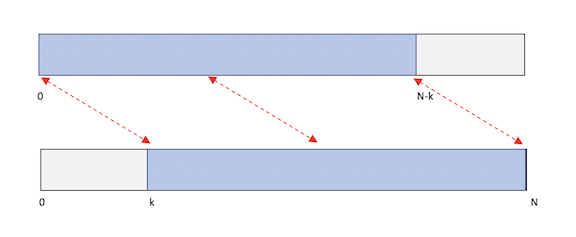

The *autocorrelation* of a signal $X$ of length $N$ is the signal consisting of lags from 0 to $\lfloor N/2\rfloor$:

$$acorr(X)\, =\, [\,  acorrK(X,0), \,acorrK(X,1), \,\ldots \, , \,acorrK(X,\lfloor N/2\rfloor \,].$$

        


As explored in lecture, when a signal is periodic, then the autocorrelation will have maximum values (form *peaks*)
when the lag $k$ is at an integer multiple of the period; the first peak will (hopefully) provide the fundamental frequency of the signal. 


Note on efficiency:  As noted above, we must generally normalize the signals to prevent arithmetic overflow when multiplying large amplitudes; I've tested this, and it is about 5x faster to normalize with an approximate standard deviation (and assuming the mean is 0.0). However, *we should perform such normalization once at the beginning, and not redo it at every value of $k$ in the formula above.* 

### Part (B)

Complete the follow template to create the autocorrelation of a signal at lag $k$. Be sure to pay attention to the advice in italics in the previous paragraph. 

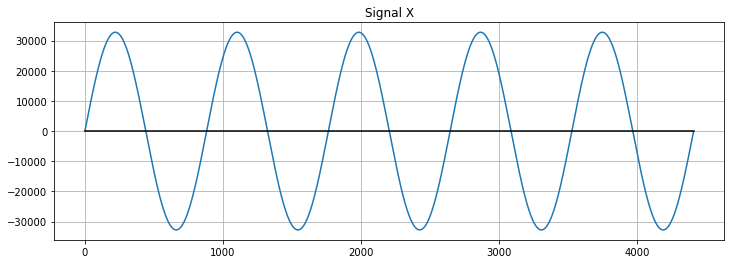

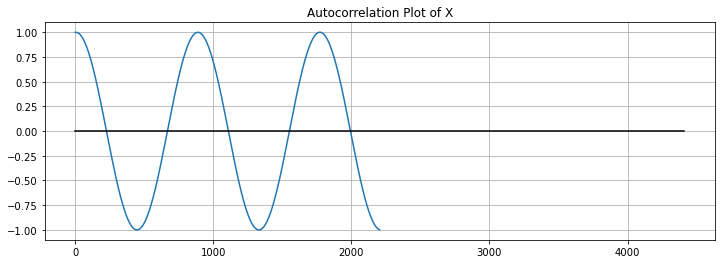

In [14]:
def acorrK(X,k,normalize=True):
    N = len(X)
    if normalize:
        X = X/stdX
    return (X[:N-k] @ X[k:]) / (N-k)



def acorr(X,normalize=True):
    N = len(X)
    if normalize:
        X = X/stdX
    return np.array(  [  acorrK(X,k,False) for k in range(len(X)//2) ]  )

# test

X = makeSignal([(50,1,0)],duration=0.1)

A = acorr(X)

plt.figure(figsize=(12,4))
plt.title("Signal X")
plt.plot(X)
plt.plot([0,len(X)],[0,0],color='k')
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
plt.title("Autocorrelation Plot of X")
plt.plot(A)
plt.plot([0,len(X)],[0,0],color='k')
plt.grid()
plt.show()

### Finding Peaks

We will use the function from HW 02 to find the peaks in the autocorrelation plot. 

Hint: Due to boundary conditions, the first couple of values in the plot may
give false positives (look like peaks); since we can not detect frequencies above the
Nyquist Limit, you should start to look for peaks starting at index 3 in the autocorrelation
(0 would be the same signal, 1 would indicate a frequency of 44.1 kHz, and 2 would indicate
a frequency of 22.05 kHz = the Nyquist Limit). 

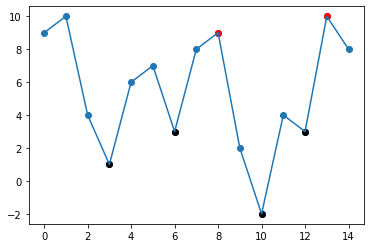

In [15]:
def find_peaks(A,relative_threshold=0.75): 
    absolute_threshold = relative_threshold * max(A)    # or could assume highest value is at A[0]    
    peaks = []
    for t in range(3,len(A)-1):             
        if A[t-1] < A[t] and A[t] > A[t+1] and A[t] > absolute_threshold:
            peaks.append(t)
    return np.array(peaks)

def find_valleys(A,relative_threshold=0.25): 
    absolute_threshold = relative_threshold * max(A)    # or could assume highest value is at A[0]    
    valleys = []
    for t in range(3,len(A)-1):             
        if A[t-1] > A[t] and A[t] < A[t+1] and A[t] < absolute_threshold:
            valleys.append(t)
    return np.array(valleys)
             
L = [9,10,4,1,6,7,3,8,9,2,-2,4,3,10,8]     

# test 

Px = find_peaks(L,0.8)
Py = [ L[x] for x in Px ]

Vx = find_valleys(L,0.8)
Vy = [ L[x] for x in Vx ]

plt.plot(L)
plt.scatter(range(len(L)),L)
plt.scatter(Px,Py,color='r')
plt.scatter(Vx,Vy,color='k')
plt.show()

### Part (C)

Complete the following template to create autocorrelation plots with identified peaks in red, as in the
previous example. 

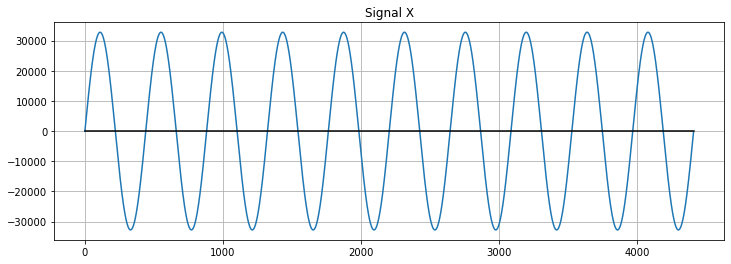

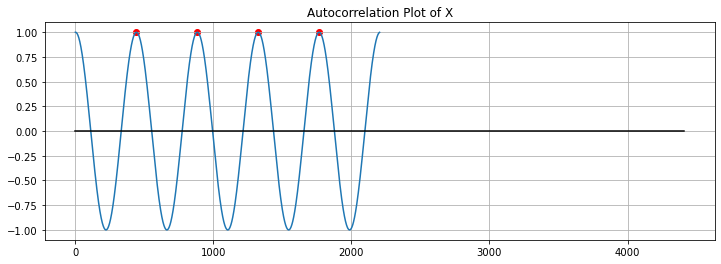

[ 442  883 1325 1766] [1.000111135606746, 1.0001426421163893, 1.0002028428020622, 1.0003109479563126]


In [16]:
def acorr_plot(X,relativeThreshold = 0.75, display=True):
    
    A = acorr(X,normalize=True)
        
    Xp = find_peaks(A,relativeThreshold)

    Yp = [ A[k] for k in Xp ]

    if display:
        plt.figure(figsize=(12,4))
        plt.title("Signal X")
        plt.plot(X)
        plt.plot([0,len(X)],[0,0],color='k')
        plt.grid()
        plt.show()

        plt.figure(figsize=(12,4))
        plt.title("Autocorrelation Plot of X")
        plt.plot(A)
        plt.scatter(Xp,Yp,color='r')
        plt.plot([0,len(X)],[0,0],color='k')
        plt.grid()
        plt.show()
    
    
    return (A,Xp,Yp)



X =  makeSignal([(100,1,0)],duration=0.1)

(A,Px,Py) = acorr_plot(X)

print(Px,Py)

### Part (D) Recursive Autocorrelation (just for fun)

The interesting thing about autocorrelation is that you can do it to any signal, and just about
everything in this course is a signal, including the autocorrelation itself. 

Plot the autocorrelation of the signal X and then perform autocorrelation on the autocorrelation. Do it once more
if you feel like it...    Be sure
you understand why this works as it does!

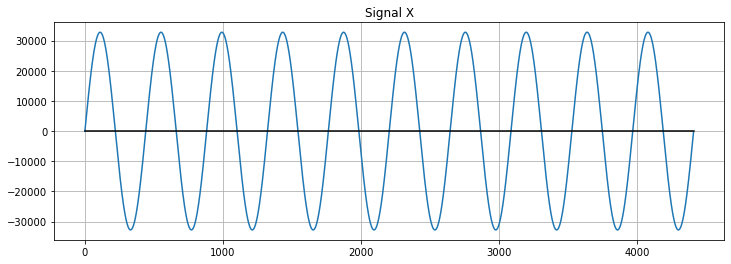

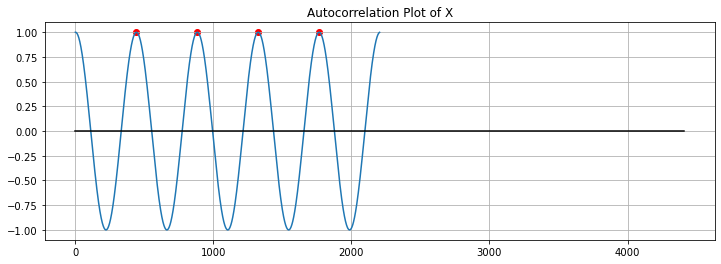

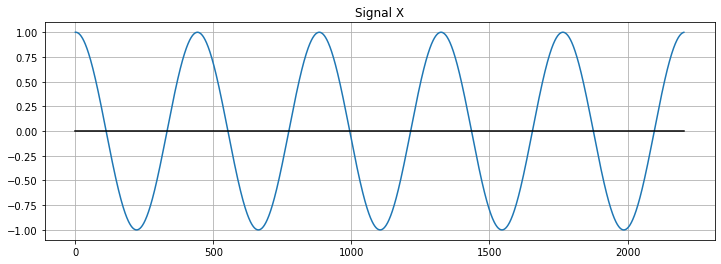

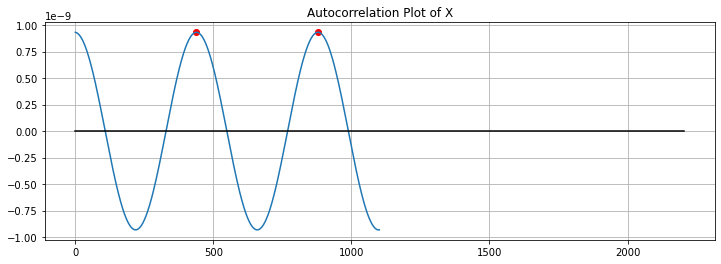

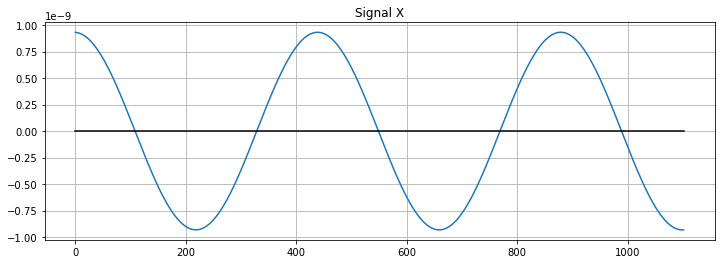

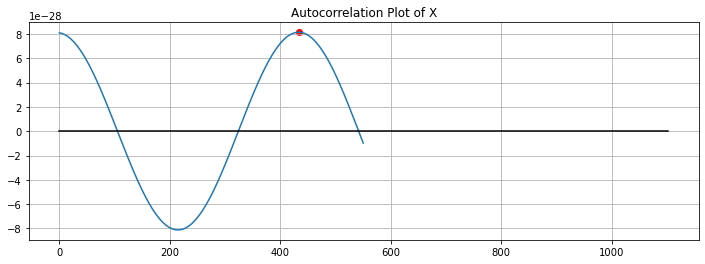

In [17]:
X =  makeSignal([(100,1,0)],duration=0.1)

(A,Px,Py)    = acorr_plot(X)

(A1,Px1,Py1) = acorr_plot(A)

(A2,Px2,Py2) = acorr_plot(A1)       # Once more with feelingg!

##  Problem Two (Pitch Determination using Autocorrelation)

### Part (A) 

A common heuristic is to use the first peak that exceeds a given relative threshold, say 0.75.
(To get the threshold in absolute terms, use `MAX_AMP * relative_threshold`.) 

For the next example,
scan through the peaks returned by the function, and find the first $t$ value for a peak where $A[t] >$ `relative_threshold`. This
is the period of the fundamental frequency F0.

Complete the following template. 

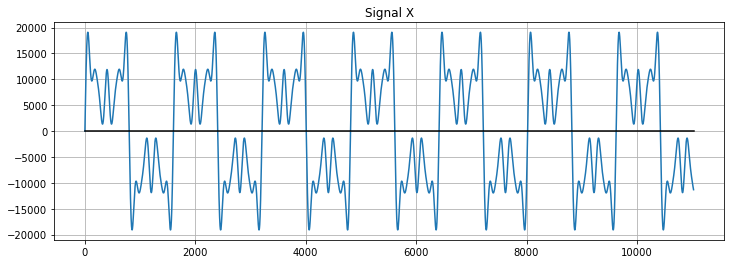

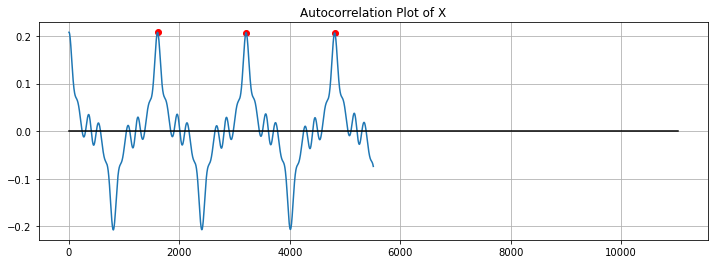

Detected Peaks:     [1604 3207 4811]
Detected Period:     1604.0
Actual Period:       1603.6363636363637
Detected Freq:       27.49376558603491
Actual Freq:         27.5
Percent Error:       0.00022670596236687082


In [18]:


def acorr_pitch(X,relative_threshold=0.75,display=True):
    
    (A,Xp,Yp) = acorr_plot(X,relative_threshold, display)
   
    period = Xp[0]
    f0 = SR/period
    
    return (A,Xp,Yp,period,f0)
    
    
# test

notename = 'A0'

f = Freqs[notename]
S = makeSpectrum('clarinet',f)
X = makeSignal(S,duration=0.25)


(A,Px,Py,p1,f1) = acorr_pitch(X)
print("Detected Peaks:    ", Px)
print("Detected Period:    ", SR/f1)
print("Actual Period:      ", SR/f)
print("Detected Freq:      ", f1)
print("Actual Freq:        ", f)
print("Percent Error:      ", (f-f1)/f)

### Improving the calculation using parabolic interpolation

When the period does not correspond to an integral number of samples,
then interpolation can be used to improve the results. For example,
in the previous example, we had the following detail around the first peak:

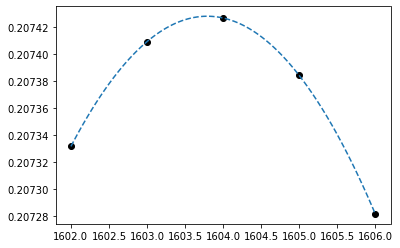

In [19]:
T = np.arange(1602,1607)
A1 = A[1602:1607]
f = interp1d(T,A1,kind='quadratic')
Tc = np.linspace(1602,1606,100)
Ac = [ f(x) for x in Tc ]
plt.plot(Tc,Ac,linestyle='--')
plt.scatter(T,A1,color='k')
plt.show()

The next cell shows
how this can be done using a standard formula. 

1603.7914461664773 0.20742774375336165


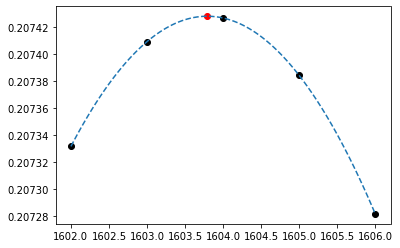

In [20]:

# Returns the (x,y) coordinates of the vertex of the parabola defined by points 
# (x1,y1), (x2,yx), (x3,y3) from the input lists:  xs = [x1,x2,x3], ys = [y1,y2,y3]

# http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points"""


def parabolicInterpolationPeak(xs,ys):
#     print(xs,ys)
    [x1, x2, x3 ] = xs
    [y1, y2, y3 ] = ys
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
    A     = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B     = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom
    f = interp1d(xs,ys,kind='quadratic')
    x = -B / (2*A)
    return  (x,f(x))

# demonstration

T = np.arange(1602,1607)
A1 = A[1602:1607]
f = interp1d(T,A1,kind='quadratic')
Tc = np.linspace(1602,1606,100)
Ac = [ f(x) for x in Tc ]
plt.plot(Tc,Ac,linestyle='--')
plt.scatter(T,A1,color='k')
(px,py) = parabolicInterpolationPeak( [1603,1604,1605], [A[1603],A[1604],A[1605]] )
print(px,py)
py = f(px)
plt.scatter([px],[py],color='r')

plt.show()

### Part (B)

Complete the following template. The basic idea is to extract the first peak location (a sample number), then use the preceeding and following sample numbers to find the
precise vertex; the x-axis value of this vertex is a float which represents
the "fractional sample number" (not an integer) for the period. 

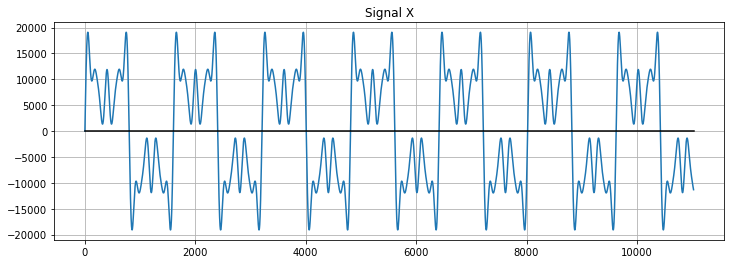

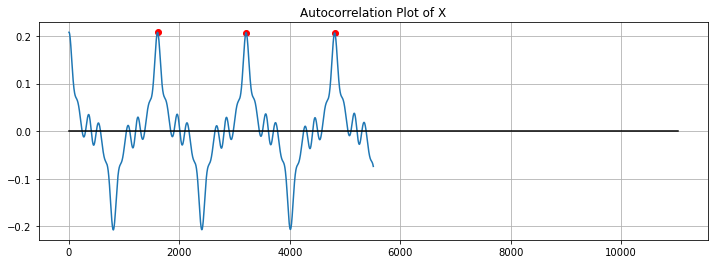

Detected Peaks:      [1604 3207 4811]
Detected Period:     1603.7914461664773
Actual Period:       1603.6363636363637
Detected Freq:       27.49734082034898
Actual Freq:         27.5
Percent Error:       9.669744185523335e-05


In [21]:

def acorr_pitch_interpolate(X,relative_threshold=0.75,display=True):
    
    (A,Xp,Yp) = acorr_plot(X,relative_threshold, display)
   
    xs = [ Xp[0]-1, Xp[0], Xp[0]+1 ]
    ys = [ A[Xp[0]-1], A[Xp[0]], A[Xp[0]+1] ]
    
    (px,py) = parabolicInterpolationPeak( xs, ys )
    period = px
    f0 = SR/period
    return (A,Xp,Yp,period,f0)
    
    
# test

notename = 'A0'

f = Freqs[notename]
S = makeSpectrum('clarinet',f)
X = makeSignal(S,duration=0.25)


(A,Px,Py,p1,f1) = acorr_pitch_interpolate(X)
print("Detected Peaks:     ", Px)
print("Detected Period:    ", p1)
print("Actual Period:      ", SR/f)
print("Detected Freq:      ", f1)
print("Actual Freq:        ", f)
print("Percent Error:      ", (f-f1)/f)

## Problem Three (Efficient Pitch Determination)

Now let's write this in a more practical way. First, if the FIRST peak is
all we need, then you should be able to write it in a more efficient way,
where you don't need to analyze the entire sequence $accorK(X,k)$ for every $k$,
but stop when you get a value over the threshold. In other words, write this
so that in the loop for $k$, if you find a value over the threshold, break
out of the loop and return the value immediately (why keep going if
you have the answer?). 

Secondly, it is possible that no peak is found (what if you give it
a signal with silence?).  In this case, return a frequency of 0.0. 


### Part (A)

Rewrite the code above to use these ideas, and run it on the same example as
in the last problem.  You should use parabolic interpolation to improve the
result, as before.  Just return the frequency calculated. It should be the same
as last time. 

In [22]:
def get_pitch(X,relative_threshold=0.75):
    N = len(X)//2
    M = acorrK(X,0)
    thresh = relative_threshold * M
    (x1,x2,x3) = (1,2,3)
    (y1,y2,y3) = (acorrK(X,1),acorrK(X,2),acorrK(X,3))
    found = False
    for k in range(2,N):
        if (y2 > y1) and (y2 > y3) and (y2 > thresh):  
            found = True
            break
        else:
            (x1,x2,x3) = (x2,x3,x3+1)
            (y1,y2,y3) = (y2,y3,acorrK(X,x3)) 
    if not found:
        return 0.0
    else:
        (x,y) = parabolicInterpolationPeak((x1,x2,x3),(y1,y2,y3))
        return SR / x

In [23]:
# test

notename = 'A0'

f = Freqs[notename]
S = makeSpectrum('clarinet',f)
X = makeSignal(S,duration=0.25)

f1 = get_pitch(X)
print("Detected Freq:      ", f1)
print("Actual Freq:        ", f)
print("Percent Error:      ", (f-f1)/f)

Detected Freq:       27.49734082034898
Actual Freq:         27.5
Percent Error:       9.669744185523335e-05


In [24]:
# test on silence

X = np.zeros(100)

f1 = get_pitch(X)
print("Detected Freq:      ", f1)

Detected Freq:       0.0


### Part (B): Fundamental Frequency of Some Real Signals

In this part we will try to determine the fundamental frequency of some actual real-world signals.

For each of the following determine the fundamental frequency, using `get_pitch`. 
Also print out the period in number of samples, and display the autocorrelation plot to check if the period seems reasonable. 

You may need to set the threshold appropriately, and to do that, you
might want to look at the autocorrelation plot!



# Pitch Determination with Search

## Problem Four (Pitch Tracking)

For this part, I would like you to use a sliding window algorithm to apply
`get_pitch` to successive windows of a real musical signal. 

I am leaving this one up to you in terms of details about how big to make
the windows, how much overlap, etc.  What you should produce is
a reasonable graph of the pitch of some simple signals. 


Apply it to the file `thelick.wav` and one other file of your choosing (make
it a real file, not a synthetic one that we made). You may want to only track
a part of the signal.  You may have to change the threshold to avoid
errors.  I got "octave errors" (right pitch class, wrong octave) when
I tried the `invention_01.wav` file, see if you can get a decent track for
some melody. 

Don't worry, this is hard, and would be a good project!

0.05 seconds


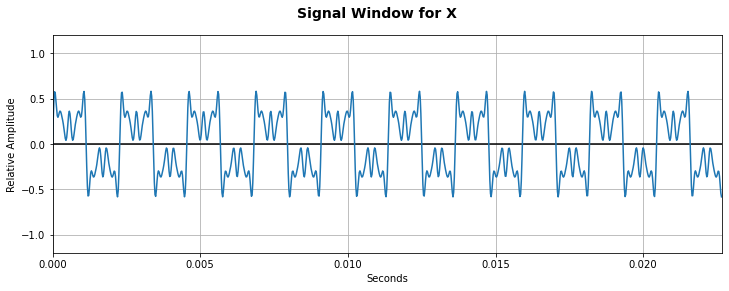

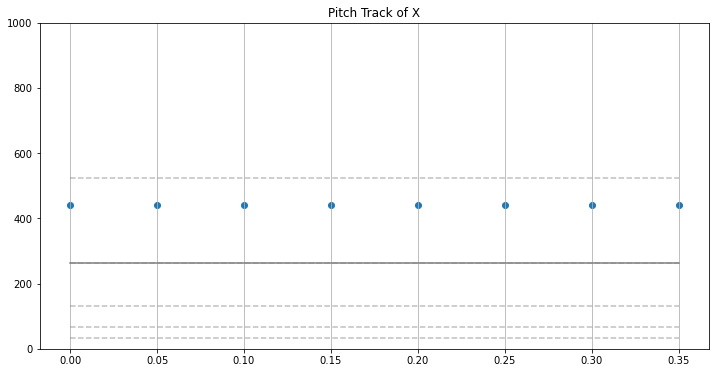

In [25]:
# Now let's do it with a sliding window. 

def get_pitch_plot(X, window_size=4410, overlap=0.5):
    N = len(X)
    lo = 0
    hi = window_size
    skip = int((1-overlap)*window_size)
    
    A = []
    while lo < N-window_size:
        f = get_pitch(X[lo:hi])
        A.append(f)
        lo += skip
        hi += skip
    return np.array(A) 

notename = 'A4'
D = 0.5
W = 4410        # window size
L = 0.5         # overlap

t = L * W / SR

print(t, 'seconds')

f = Freqs[notename]
S = makeSpectrum('clarinet',f)
X = makeSignal(S,duration = D)

displaySignal(X[:1000])

P = get_pitch_plot(X,W,L)
T = np.arange(0,len(P)*t,t)
freqLimit = 1000
plt.figure(figsize=(12,6))
plt.title("Pitch Track of X")
plt.ylim(0,freqLimit)
# draw note names for C's in all octaves
C1 = Freqs['C1']
C4 = Freqs['C4']
Cs = [ C1 * (2**k) for k in range(8) if (C1*(2**k)) <= freqLimit ]
for f in Cs:
    plt.plot( [0,T[-1]], [f,f], color='grey', alpha=0.5, linestyle='--' )
plt.plot( [0,T[-1]], [C4,C4], color='grey' )
plt.scatter(T,P)
plt.grid(axis='x')
plt.show()

In [26]:
# P = get_pitch_plot(Xd1,W,L)
# T = np.arange(0,len(P)*t,t)

# freqLimit = 1000
# plt.figure(figsize=(12,6))
# plt.title("Pitch Track of X")
# plt.ylim(0,freqLimit)
# # draw lines for C's in all octaves
# C1 = Freqs['C1']
# C4 = Freqs['C4']
# Cs = [ C1 * (2**k) for k in range(8) if (C1*(2**k)) <= freqLimit ]
# for f in Cs:
#     plt.plot( [0,T[-1]], [f,f], color='grey', alpha=0.5, linestyle='--' )
# plt.plot( [0,T[-1]], [C4,C4], color='grey' )
# # plt.plot(T,P)
# plt.scatter(T,P)
# plt.grid(axis='x')
# plt.show()

In [27]:
# Xd2 = readWaveFile('invention_01.wav')[:SR*4]

# P = get_pitch_plot(Xd2,W,L)
# T = np.arange(0,len(P)*t,t)


# freqLimit = 1000
# plt.figure(figsize=(12,6))
# plt.title("Pitch Track of X")
# plt.ylim(0,freqLimit)
# # draw note names for C's in all octaves
# C1 = Freqs['C1']
# Cs = [ C1 * (2**k) for k in range(8) if (C1*(2**k)) <= freqLimit ]
# for f in Cs:
#     plt.plot( [0,T[-1]], [f,f], color='grey', alpha=0.5, linestyle='--' )
# plt.plot( [0,T[-1]], [C4,C4], color='grey' )
# plt.scatter(T,P)
# plt.grid(axis='x')
# plt.show()

In [28]:
# X = np.zeros(SR)
# X[10000] = MAX_AMP

# displaySignal(X)

# S = realFFT(X)

# # plt.figure(figsize=(12,6))
# # plt.title("Spectrum with Linear Scale on Magnitude Axis")
# # plt.magnitude_spectrum(X,SR)
# # plt.show()

# # 1000    1.48603175
# # 100     1.48603175

# plt.plot(S)

# print(S[:10])
# print(S[-10:])

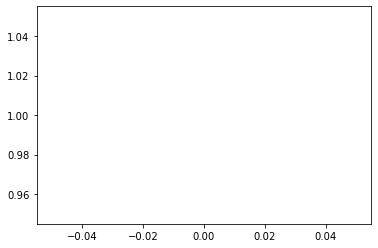

In [29]:
plt.plot([0,0],[1,1])

In [30]:
# def argand(a):
#     plt.figure(figsize=(6,6))
#     for x in range(len(a)):
#         plt.plot([0,a[x].real],[0,a[x].imag],'ro-',label='python')
#     limit=2*np.max(np.ceil(np.absolute(a))) # set limits for axis
#     plt.xlim((-limit,limit))
#     plt.ylim((-limit,limit))
#     plt.ylabel('Imaginary')
#     plt.xlabel('Real')
#     plt.show()
    
#     plt.figure(figsize=(6,6))
#     plt.scatter(list(range(len(a))),np.absolute(a))
#     for x in range(len(a)):
#         plt.plot([x,x],[0,abs(a[x])],'k')
#     plt.show()
    
#     from scipy.fft import fft, ifft
    
# import numpy as np    
# x = np.zeros(1000)
# for i in range(100):
#     x[i] = 1
# y = fft(x)




# # print(y)

# # print(abs(y))

# # argand(y)

## Audio Sample Files for Pitch Determination

The first collection are extracted from actual recordings, with an
estimate of the actual pitch

In [31]:
# Put full path name to repository of audio files

path = "/Users/snyder/Documents/Teaching/CS 583/Web/AudioFiles/PitchDetermination/"       



In [32]:
## Pulsar

X = readWaveFile(path+"pulsar.wav")
print("Pulsar\t" + str(len(X)/SR) + " secs.")

windowStart = 0
windowLength = 2210     # 1/20 sec
# windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)


f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/snyder/Documents/Teaching/CS 583/Web/AudioFiles/PitchDetermination/pulsar.wav'

In [ ]:
# Steel String

X = readWaveFile(path + "realSteelString.A3.wav")

print("Steel String Guitar\t" + str(len(X)/SR) + " secs.")

windowStart = 1000
windowLength = 2210     # 1/20 sec
# windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

Audio(X,rate=SR)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Next is a recording of a bell; you'll probably need to set a lower threshold for this. 

In [ ]:
X = readWaveFile(path+"realBell.wav")

print("Bell\t" + str(len(X)/SR) + " secs.")

windowStart = 1100
windowLength = 2210     # 1/20 sec
# windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = readWaveFile(path+"invention.C4.wav")

print("Bach Invention One\t" + str(len(X)/SR) + " secs.")

windowStart = int(SR*0.34)
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = readWaveFile(path+"realClarinet.A4.wav")

print("Clarinet\t" + str(len(X)/SR) + " secs.")

windowStart = int(SR*0.2)
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = readWaveFile(path+"realTrumpet.A4.wav")

print("Trumpet\t" + str(len(X)/SR) + " secs.")

windowStart = int(SR*0.4)
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = readWaveFile(path+"realBachFugue.G4.wav")

print("Bach G Minor Fugue\t" + str(len(X)/SR) + " secs.")

windowStart = int(SR*1.0)
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = readWaveFile(path+"realShakuhachiFlute.wav")

print("Shakuhachi Flute:\t" + str(len(X)/SR) + " secs.")

windowStart = int(SR*3.1)
windowLength = 2210     # 1/20 sec
# windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = readWaveFile(path+"Beethoven.Seventh.wav")

print("Beethoven Seventh Symphony:\t" + str(len(X)/SR) + " secs.")

windowStart = int(SR*1.0)
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = readWaveFile(path+"Bach.Brandenburg.wav")

print("Bach Second Brandenburg Concerto\t" + str(len(X)/SR) + " secs.")

windowStart = int(SR*0.55)
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = readWaveFile(path+"heartbeat.wav")

print("Heartbeat\t" + str(len(X)/SR) + " secs.")

windowStart = int(SR*1.0)
# windowLength = 2210     # 1/20 sec
# windowLength = 4410     # 1/10 sec
windowLength = 44100*3     # 3 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

# f = get_pitch(X)
# print("Detected Freq:   ", f, "Hz.")
# print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [87]:
X = readWaveFile(path+"Prince_A Case of You.wav")

print("Prince: A Case of You \t" + str(len(X)/SR) + " secs.")

windowStart = int(SR*6)
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/snyder/Documents/Teaching/CS 583/Web/AudioFiles/PitchDetermination/Prince_A Case of You.wav'

In [93]:
# File: Yin.py
# Author: Wayne Snyder
# Date: Jul 30 2020
# Description: This is an implementation of the Yin Algorithm, from
#        http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf


def Yin(X,t=0,window_size=4410,threshold=0.1,display=False):

    # normalize X to prevent overflow when multiplying
    X = np.array([x/MAX_AMP for x in X])

    W = window_size//2    # can only calculate lag times up to half of window size
    
    X1 = X[t:(t+W)]       # stationary window of width W

    # Calculate d_t(tau),  p.1919
    
    d_t = np.array([np.sum((X1 - X[(tau+t):(tau+t+W)])**2) for tau in range(W)])

    # Calculate the cumulative mean normalized difference function d1_t(tau) = d'_t(tau)
    
    #  d1_t(tau) = 1 for tau = 0
    #            = d_t(tau) / mean(d_t(1), ..., d_t(tau))  otherwise
    #              = tau*d_t(tau)/(d_t(1)+ ... +d_t(tau))
    
    # Cumulative sum of [x0,x1,x2, .... ] is [x0, x0+x1, x0+x1+x2, ... ]
    # so this will calculate the denominator above:
    
    cumm_d_t = np.cumsum(d_t)

    d1_t = np.array([ 1 if (tau==0) else tau*d_t[tau]/cumm_d_t[tau] for tau in range(W)])

    # Now calculate minima in d1_t and find first one that is below
    # a fixed threshold; if none is below threshold, then choose overall global minimum
    
    # note that you can't choose tau as last slot (len(d1_t)-1) because such a tau = 
    # can never be a "valley" (it doesn't have a right neighbor to be less than). 
    # Similarly, tau can not be < 3 because tau = 2 corresponds to period 2, and 
    # frequency 44100/2 = 22050 = Nyquist Limit!

    tau = None
    
    for t1 in range(3,len(d1_t)-1):             
        if d1_t[t1] < threshold and d1_t[t1-1] > d1_t[t1] and d1_t[t1] < d1_t[t1+1]:
            tau = t1
            break
            
    if tau == None:
#         print("Warning: Using global minimum!")
        # index of first global minimum
        # but not the very last slot (cf. len(d1_t)-1 above), so find min in d1_t[:-1]
        tau = (np.where(d1_t[:-1] == np.amin(d1_t[:-1])))[0][0]
        
    (x1,x2,x3) = (tau-1,tau,tau+1)
    (y1,y2,y3) = (d1_t[tau-1],d1_t[tau],d1_t[tau+1])
    

    A = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2))   
    B = (x3**2 * (y1 - y2) + x2**2 * (y3 - y1) + x1**2 * (y2 - y3)) 
    
    interpolated_tau = - B/(2*A)

    if display:
     
        plt.figure(figsize=(10,5))
        plt.title("Signal Window")
        plt.plot(X1)
        plt.show()
        
        plt.figure(figsize=(10,5))
        plt.title("Difference Function")
        plt.plot(d_t)
        plt.show()
        
        plt.figure(figsize=(10,5))
        plt.title("Normalized Difference Function")
        plt.plot(d1_t)
        plt.show()

    return ( SR/interpolated_tau, SR/tau,d_t,d1_t)

## Some synthetic signals....

In [ ]:
fbase= 440.0

In [ ]:
X = makeSignal(makeSpectrum('triangle',fbase))

print("Synthetic Triangle Wave\t" + str(len(X)/SR) + " secs.")

windowStart = 0
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

X = makeSignal([(fbase, 1, 0)])
displaySignal(X)
a,b,c,d = Yin(X)
print("Yin freq:",a)
print(b)
print(c)
print(d)

Audio(X,rate=SR)

In [ ]:
X = makeSignal(makeSpectrum('square',fbase))

print("Synthetic Square Wave\t" + str(len(X)/SR) + " secs.")

windowStart = 0
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = makeSignal(makeSpectrum('clarinet',fbase))

print("Synthetic Clarinet\t" + str(len(X)/SR) + " secs.")

windowStart = 0
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = makeSignal(makeSpectrum('bell',fbase))

print("Synthetic Bell\t" + str(len(X)/SR) + " secs.")

windowStart = 0
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)

In [ ]:
X = makeSignal(makeSpectrum('steelstring',fbase))

print("Synthetic Steel String Guitar\t" + str(len(X)/SR) + " secs.")

windowStart = 0
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

print("Window Start: " + str(windowStart))
print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR) 

In [ ]:
X = makeSignal(makeSpectrum('organ',fbase))            # to get rid of 0 at beginning

print("Synthetic Organ\t" + str(len(X)/SR) + " secs.")

windowStart = 0
# windowLength = 2210     # 1/20 sec
windowLength = 4410     # 1/10 sec

# print("Window Start: " + str(windowStart))
# print("Window Length: " + str(windowLength))

X = X[windowStart:(windowStart+windowLength)]

X2 = X**2
# logX = np.log(X2)
min(X2)
for k in range(len(X2)):
    if X2[k] < 50:
        print(k,X2[k])

In [ ]:
displaySignal(X)

f = get_pitch(X)
print("Detected Freq:   ", f, "Hz.")
print("Detected Period: ",SR/f, "samples.")

Audio(X,rate=SR)  

In [ ]:
realSamples = [("Hungarian Dance No. 5.wav",2.75),
 ("Bach.BrandenBurg.wav",7.9),
 ("Beethoven.Seventh.wav",0.9),
 ("blues.00010.wav",8),
 ("blues.00022.wav", 13.5),
 ("blues.00040.wav", 7.18),
 ("classical.00011.wav", 0.5),
 ("classical.00022.wav", 8.6),
 ("classical.00031.wav", 8.42),
 ("classical.00043.wav", 4.23),
 ("classical.00071.wav", 18),
 ("crash.wav", 0),
 ("disco.00005.wav", 0),
 ("disco.00022.wav", 2.22),
 ("disco.00041.wav", 10.6),
 ("heartbeat.wav", 0),
 ("invention.C4.wav", 0.34),
 ("jazz.00004.wav", 7.424),
 ("jazz.00024.wav", 3.4),
 ("jazz.00036.wav", 14.248),
 ("jazz.00055.wav", 11.8),
 ("jazz.00093.wav", 1.42),
 ("metal.00005.wav", 2.42),
 ("metal.00032.wav", 3),
 ("MyOldKentuckyHome.wav", 4.494),
 ("MysterySignal01.wav", 0),
 ("pop.00005.wav", 9.868),
 ("Prince_A Case of You.wav", 5.227),
 ("pulsar.wav", 0),
 ("realBachFugue.G4.wav", 0.87),
 ("realBell.wav", 0.025),
 ("realClarinet.A4.wav", 0.15),
 ("realOboe.A4.wav", 0.2),
 ("realShakuhachiFlute.wav", 1),
 ("realSteelString.A3.wav", 0.025),
 ("realTrumpet.A4.wav", 0.3),
 ("reggae.00004.wav", 3.66),
 ("reggae.00065.wav", 5.55),
 ("ride-bell.wav", 0.001),
 ("rock.00043.wav", 0.733),
 ("rock.00051.wav", 0.7),
 ("rock.00087.wav", 13.2),
 ("rock.00095.wav", 1.105),
 ("rock.00099.wav", 5.16)       ]

for k in range( len(realSamples) ):
    print(k, ":", realSamples[k])
    

In [ ]:
path

In [ ]:
dur = 0.1
for k in range(len(realSamples)):
    X = readWaveFile(path+realSamples[k][0])
    ( f, y2,t,W ) = Yin(X,int(SR*realSamples[k][1]),int(SR*dur))
    print(k, "\t", realSamples[k][0], "\t", f)

## Synthetic Pitch Samples using makeSpectrum

In [ ]:
f = 12.3456789012345
mult = 10

FS = [f*(mult**k) for k in range(4)]

print(FS)

instruments =    ['triangle','square', 'bell', 'organ', 'steelstring', 'clarinet']

syntheticSampleLabels = [ (i, p) for i in instruments for p in FS]
syntheticSamples = [ scaleSignal(makeNote(i, pitch=p)) for i in instruments for p in FS]

print()
for k in range( len(syntheticSampleLabels) ):
    print(k, ":", syntheticSampleLabels[k])

In [ ]:
displaySignal(syntheticSamples[16])
displaySignal(syntheticSamples[17])
displaySignal(syntheticSamples[18])
displaySignal(syntheticSamples[19])

In [88]:
dur = 0.1
for k in range(len(syntheticSamples)):
    X = syntheticSamples[k]
    ( f, y2,t,W ) = Yin(X,0,int(SR*dur))
    print(k, "\t", syntheticSampleLabels[k][0], "\t", f)

NameError: name 'syntheticSamples' is not defined

## Synthetic by peak-picking spectral points of real signals

In [ ]:
def displaySpectrum(F,S=[],relative=False, labels=True, printSpectrum=True, logscaleX = False, logscaleY = False):
    fig = plt.figure(figsize=(10,3))          # Set x and y dimensions of window: may need to redo for your display
    fig.suptitle('Spectrum', fontsize=14, fontweight='bold')
    ax = plt.axes()
    
    # convert from pairs or triples to F and S

    if(type(F[0])==tuple or type(F[0])==list):
        if(len(F[0]) == 3):
            S = [a for (f,a,phi) in F]
            F= [f for (f,a,phi) in F]
        elif(len(F[0]) == 2):
            S = [a for (f,a) in F]
            F= [f for (f,a) in F]

    # cleanup by removing all close to 0 if only a few above 0
    count = 0           
    for i in range(len(F)):
        if(S[i] >= 0.001 or S[i] <= -0.001):
            count +=1
            
    if(count <= 20):
        tempS = S
        tempF = F
        S = []
        F = []
        for k in range(len(tempS)):
            if(tempS[k] >= 0.001 or tempS[k] <= -0.001):
                S.append(tempS[k])
                F.append(tempF[k])
                
    if(relative and max(S) > 100):
        for k in range(len(S)):
            S[k] = S[k]/MAX_AMP
            
    S = [np.round(x,4) for x in S]            # round to 4 decimal places
                
    if(logscaleX):
        ax.set_xscale('log')
        minX = 10
        maxX = 22050
    else:
        if(max(F) < 0):
            maxX = 0.0
        else:
            maxX = min(SR/2,max(F) * 1.2)
        if(min(F) < 0):          # negative frequencies
            minX = min(F) * 1.2
        else:
            minX = 0

    if(logscaleY):
        ax.set_yscale('log')
        minY = 1
        maxY = 32767
    else:
        if(min(S) < 0):          # negative amplitudes
            minY = min(S) * 1.2
            plt.plot([minX,maxX],[0,0],color='k', linestyle='-', linewidth=1)
        else:
            minY = 0
        if(max(S) < 0):
            maxY = 0.0
        else:
            maxY = max(S) * 1.2
        
    ax.set_xlim([minX,maxX])
    ax.set_ylim([minY,maxY])
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    width = maxX - minX
    
    numBins = 50     # upper bound for when print lollipop spectrum
    
    if(len(F) <= numBins):
        for i in range(len(F)):
            if(S[i] > 0.0):
                plt.plot([F[i], F[i]], [0,S[i]], color='k', linestyle='-', linewidth=1)
                plt.plot([F[i]], [S[i]],'ro')
                if(labels):
                    plt.text(F[i]+width/70,S[i], str(S[i]),fontsize=8)
            elif(S[i] < 0.0):
                plt.plot([F[i], F[i]], [S[i],0], color='k', linestyle='-', linewidth=1)
                plt.plot([F[i]], [S[i]],'ro')
                if(labels):
                    plt.text(F[i]+width/70,S[i], str(S[i]),fontsize=8)
    else:
        ax.set_xlim([minX/1.2,maxX/1.2+10])
        plt.plot(F,S)
        
    plt.show()

In [ ]:
# Find the spectrum of a window and return a spectrum of (freq,amp) pairs
    
def getSpectrum(X):
    S = realFFT(X)
    F = np.arange(0,len(X)/2+1)*SR/len(X)
    return zip(F,S)
    
# Find spectrum of window X and display with frequencies
   
def analyzeSpectrum(X,standard = True, logscaleX = True, logscaleY = True):
    S = realFFT(X)
    F = np.arange(0,len(X)/2+1)*SR/len(X)
    displaySpectrum(F,S,standard,logscaleX,logscaleY) 


## Comparative Study of Different Pitch Determination Algorithms

In [ ]:
# X = readWaveFile(path+"invention.C4.wav")
X = makeSignal([(441,0.5,0),(882,0.25,0),(441*3,0.15,0),(441*4,0.10,0)])
displaySignal(X[:1000])
Audio(X,rate=SR)

In [ ]:
f = Freqs['C4']
print("ground truth f0:", np.around(f,5), "Hz")
print("ground truth period:", np.around(SR/f,5), "samples")

In [ ]:
start = 0.34
duration = 0.1
X1 = X[int(start*SR):int((start+duration)*SR)]

displaySignal(X1)
Audio(X1,rate=SR)

In [ ]:
(A,Px,Py,p1,f1) = acorr_pitch_interpolate(X1)
print("Detected Peaks:     ", Px)
print("Detected Period:    ", p1)
print("Actual Period:      ", SR/f)
print("Detected Freq:      ", f1)
print("Actual Freq:        ", f)
print("Percent Error:      ", np.around(100*(f-f1)/f,6), "%")

In [ ]:
relativeThreshold = 0.75
A = acorr(X1,normalize=True)
        
Xp = find_peaks(A,relativeThreshold)

Yp = [ A[k] for k in Xp ]

plt.figure(figsize=(12,4))
plt.title("Autocorrelation Plot of X")
plt.plot(A)
plt.scatter(Xp,Yp,color='r')
plt.grid()
plt.show()
print("Peaks at: ", Xp)

# def Yin(X,t=0,window_size=4410,threshold=0.1,display=False):
#     return ( SR/interpolated_tau, SR/tau,d_t,d1_t)

(f_interp,f_nointerp,diff_func,norm_diff_func) = Yin(X1)

plt.figure(figsize=(12,6))
plt.title("Difference Function")
plt.plot(diff_func)
Xp = find_valleys(diff_func,0.75)
Yp = [ diff_func[k] for k in Xp ]
plt.scatter(Xp,Yp,color='r')
plt.grid()
plt.show()
print("Peaks at: ", Xp)

        
plt.figure(figsize=(12,6))
plt.title("Normalized Difference Function")
plt.plot(norm_diff_func)
Xp = find_valleys(norm_diff_func,0.75)
Yp = [norm_diff_func[k] for k in Xp] 
plt.scatter(Xp,Yp,color='r')
plt.grid()
plt.show()
print("Peaks at: ", Xp)

In [ ]:
X2 = np.hanning(len(X1)) * X1 # window func
displaySignal(X2)

In [ ]:
X2 = np.hanning(len(X1)) * X1 # window func
spect = np.fft.rfft(X2)
spect = np.abs(spect)

freq_vector = np.fft.rfftfreq(len(X2), d=1/SR)
dt = freq_vector[1] - freq_vector[0]
#print(freq_vector[1])

lo = int(min_freq / dt)
hi = int(max_freq / dt)

# print(lo,hi,freq_vector[:5])
#print(spect)
plt.figure(figsize=(12,6))
plt.title("Magnitude Spectrum")
plt.plot(freq_vector[lo:hi+1], spect[lo:hi+1])
plt.show()

spect = np.log(spect)
plt.figure(figsize=(12,6))
plt.title("Log Spectrum")
plt.plot(freq_vector[lo:hi+1], spect[lo:hi+1])
plt.show()


In [ ]:
cept = np.fft.rfft(spect)
cept = np.abs(cept)
#cept = np.log(cept)
#print(len(spect))

cept = cept[1:]       # get rid of first slot = 0

dt = freq_vector[1] - freq_vector[0]
# print("dt = ", dt)
qerf_axis = np.fft.rfftfreq(len(spect), d=dt) 
qerf_axis = qerf_axis[1:]
freq_axis = [ 1/x for x in qerf_axis]


In [ ]:
1/0.00226655

In [ ]:
# find lower bound on piano
lo_bound = 10
for k in range(len(freq_axis)): 
#     print(k, freq_axis[k])
    if (freq_axis[k] < min_freq):
        lo_bound = k
    else:
        break
    
# print(lo_bound)

n = np.argmax(cept[lo_bound:])
n += lo_bound

plt.figure(figsize=(12,6))
plt.title("Cepstrum")
plt.plot(freq_axis[lo_bound:],cept[lo_bound:])
plt.show()
print("Peak at: ", freq_axis[n], "Hz.")

## Histogram Method for Determining F0

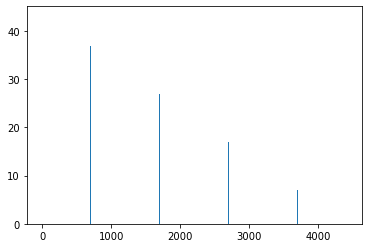

In [94]:
# find locations for building histogram
# this one is zero-crossings

def findLocations(X):
#     return findZeroCrossings(X)
    return findPeaks(X)

def findZeroCrossings(X):
    ZC = []
    for k in range(1,len(X)-1):
        if X[k] == 0 and ((X[k-1] > 0 and X[k+1] < 0) or (X[k-1] < 0 and X[k+1] > 0)):
            ZC.append(k)
        elif (X[k] > 0 and X[k+1] < 0) or (X[k] < 0 and X[k+1] > 0):
            f = interp1d([X[k],X[k+1]],[k,k+1], kind='linear')
            ZC.append(f(0))
    return np.array(sorted(ZC))
    
def findPeaks(X):
    PS = []
    for k in range(1,len(X)-1):
        if X[k] > 0 and X[k-1] < X[k] and X[k+1] < X[k]:
            PS.append(k)
    return np.array(sorted(PS))

# Test
# X = [2,3,2,-1,-2,0,1,0,2,-3,2,5,3,0,.4,-2,-3,5]

# plt.plot(X)
# plt.plot([0,len(X)],[0,0],color='k')
# plt.show()

# findPeaks(X)

# returns all possible intervals between locations in L
def allIntervals(L):
    IS = []
    for i in range(len(L)-1):
        for j in range(i+1,len(L)):
            IS.append(L[j]-L[i])
    return np.array(IS)

L = findLocations(X1)
# print(L)

I = sorted(allIntervals(L))
# print(sorted(I)) 

bins = [-0.5]+[x+0.5 for x in range(len(X1)+1)]
Z = plt.hist(I,bins)

###   Display All Metrics

In [95]:
# Display all possible analyses

def displayAllMetrics(X,start=0,duration=0.1,f_reference=None):
    
    X1 = X[int(start*SR):int((start+duration)*SR)]

    displaySignal(X1,xUnits = "Samples")


    relativeThreshold = 0.75
    A = acorr(X1,normalize=True)

    Xp = find_peaks(A,relativeThreshold)

    Yp = [ A[k] for k in Xp ]

    plt.figure(figsize=(12,4))
    plt.title("Autocorrelation Plot of X")
    plt.plot(A)
    plt.scatter(Xp,Yp,color='r')
    plt.xlabel("Sample Number")
    plt.grid()
    plt.show()
#     print("Peaks at: ", Xp)
    
    (A,Px,Py,p1,f1) = acorr_pitch_interpolate(X1,display=False)
#     print("Detected Peaks:     ", Px)
    print("Detected Period:    ", p1)
    print("Detected Freq:      ", f1)
    if f_reference != None:
        print("Actual Period:      ", SR/f_reference)
        print("Actual Freq:        ", f_reference)
        print("Percent Error:      ", np.around(100*(f_reference-f1)/f_reference,6), "%")

    # def Yin(X,t=0,window_size=4410,threshold=0.1,display=False):
    #     return ( SR/interpolated_tau, SR/tau,d_t,d1_t)

    (f_interp,f_nointerp,diff_func,norm_diff_func) = Yin(X1)

    plt.figure(figsize=(12,6))
    plt.title("Difference Function")
    plt.plot(diff_func)
    Xp = find_valleys(diff_func,0.75)
    Yp = [ diff_func[k] for k in Xp ]
    plt.scatter(Xp,Yp,color='r')
    plt.xlabel("Sample Number")
    plt.grid()
    plt.show()
#     print("Valleys at: ", Xp)


    plt.figure(figsize=(12,6))
    plt.title("Normalized Difference Function")
    plt.plot(norm_diff_func)
    Xp = find_valleys(norm_diff_func,0.75)
    Yp = [norm_diff_func[k] for k in Xp] 
    plt.scatter(Xp,Yp,color='r')
    plt.xlabel("Sample Number")
    plt.grid()
    plt.show()
#     print("Valleys at: ", Xp)
    
    print("Yin Detected F0 (no interpolation):  ", f_nointerp)
    print("Yin Detected F0 (with interpolation):", f_interp)
    if f_reference != None:
        print("Actual Period:      ", SR/f_reference)
        print("Actual Freq:                         ", f_reference)
        print("Percent Error (no interp):  ", np.around(100*(f_reference-f_nointerp)/f_reference,6), "%")
        print("Percent Error (interp):     ", np.around(100*(f_reference-f_interp)/f_reference,6), "%")
        
    X2 = np.hanning(len(X1)) * X1 # window func
    spect = np.fft.rfft(X2)
    spect = np.abs(spect)

    freq_vector = np.fft.rfftfreq(len(X2), d=1/SR)
    dt = freq_vector[1] - freq_vector[0]
    

    lo = int(min_freq / dt)
    hi = int(max_freq / dt)

    plt.figure(figsize=(12,6))
    plt.title("Magnitude Spectrum")
    plt.plot(freq_vector[lo:hi+1], spect[lo:hi+1])
    plt.xlabel("Frequency in Hz")
    plt.show()

    spect = np.log(spect)
    plt.figure(figsize=(12,6))
    plt.title("Log Spectrum")
    plt.plot(freq_vector[lo:hi+1], spect[lo:hi+1])
    plt.xlabel("Frequency in Hz")
    plt.show()
    
    cept = np.fft.rfft(spect)
    cept = np.abs(cept)
    #cept = np.log(cept)
    #print(len(spect))

    cept = cept[1:]       # get rid of first slot = 0

    dt = freq_vector[1] - freq_vector[0]
    # print("dt = ", dt)
    qerf_axis = np.fft.rfftfreq(len(spect), d=dt) 
    qerf_axis = qerf_axis[1:]
    freq_axis = [ 1/x for x in qerf_axis]

    # find lower bound on piano
    lo_bound = 10
    for k in range(len(freq_axis)): 
    #     print(k, freq_axis[k])
        if (freq_axis[k] < min_freq):
            lo_bound = k
        else:
            break
 

    n = np.argmax(cept[lo_bound:])
    n += lo_bound

    plt.figure(figsize=(12,6))
    plt.title("Cepstrum")
#     plt.plot(freq_axis[lo_bound:],cept[lo_bound:])
    plt.plot(freq_axis[lo_bound:],cept[lo_bound:])
    plt.xlabel("Frequency in Hz")
    plt.show()
    print("Peak at: ", freq_axis[n], "Hz.")
    
    L = findLocations(X1)
    # print(L)

    I = sorted(allIntervals(L))
    # print(sorted(I)) 

    bins = [-0.5]+[x+0.5 for x in range(len(X1)+1)]
    plt.figure(figsize=(12,6))
    plt.title("Histogram of Intervals between Peaks")
    (H,B,_)=plt.hist(I,bins)
    plt.show()
    m = np.argmax(H)
    print("Peak at: ", SR/m, "Hz.")

### Synthetic wave at 441Hz (3 harmonics)

WS Comment: works well everywhere

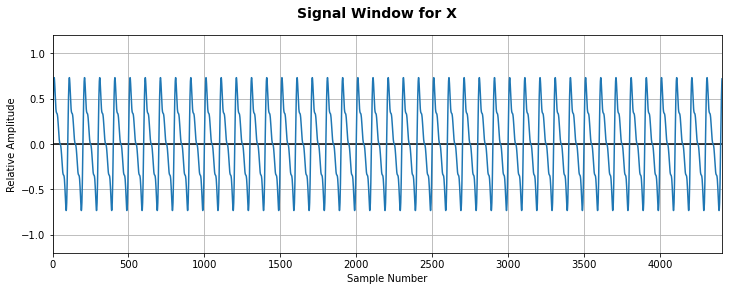

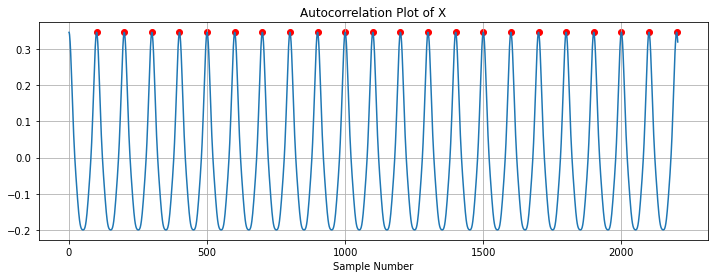

Detected Period:     99.98748731287185
Detected Freq:       441.0551878557189
Actual Period:       100.0
Actual Freq:         441.0
Percent Error:       -0.012514 %


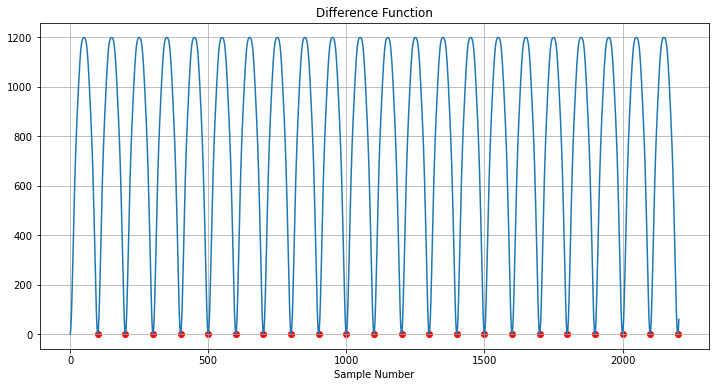

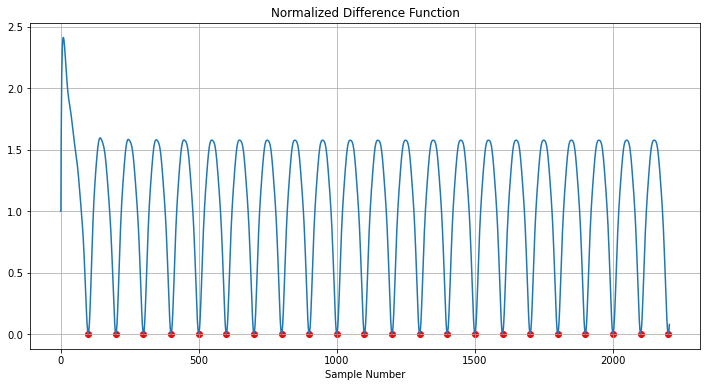

Yin Detected F0 (no interpolation):   441.0
Yin Detected F0 (with interpolation): 441.0202559307949
Actual Period:       100.0
Actual Freq:                          441.0
Percent Error (no interp):   0.0 %
Percent Error (interp):      -0.004593 %


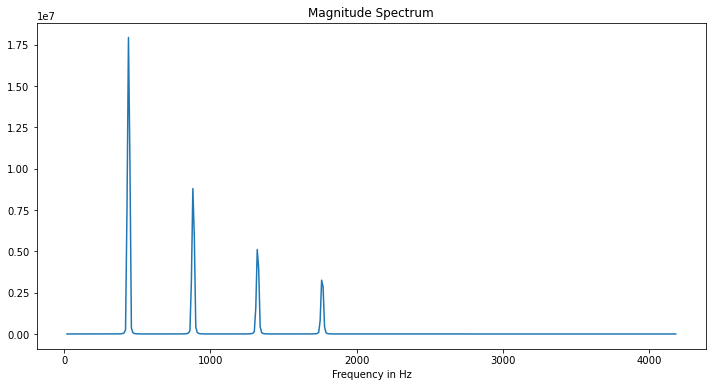

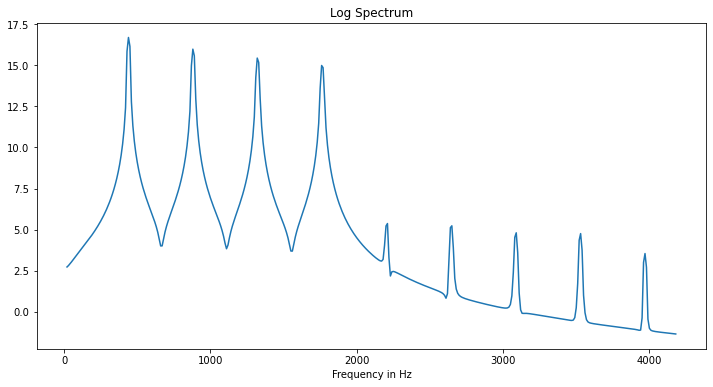

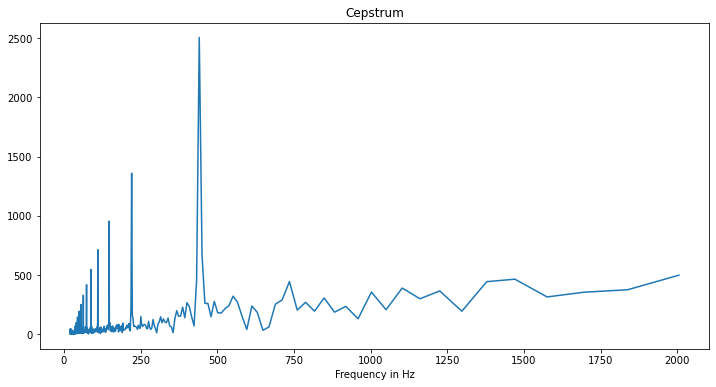

Peak at:  441.2 Hz.


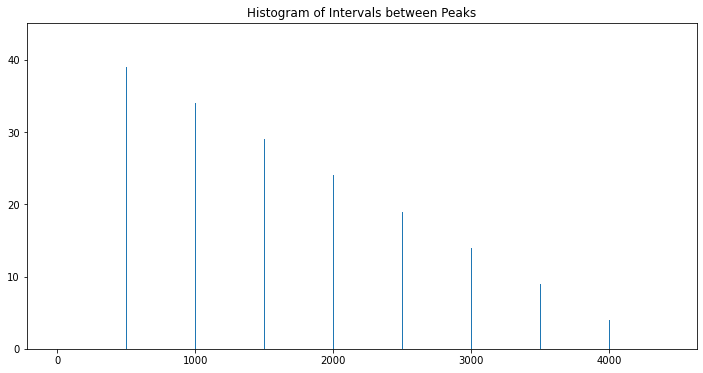

Peak at:  441.0 Hz.


In [96]:
X = makeSignal([(441,0.5,0),(882,0.25,0),(441*3,0.15,0),(441*4,0.10,0)])
displayAllMetrics(X,0.0,0.1,441.0)

### Synthetic Wave at 234.56789 Hz (with 5 harmonics)


WS Comment:   Works well everywhere 

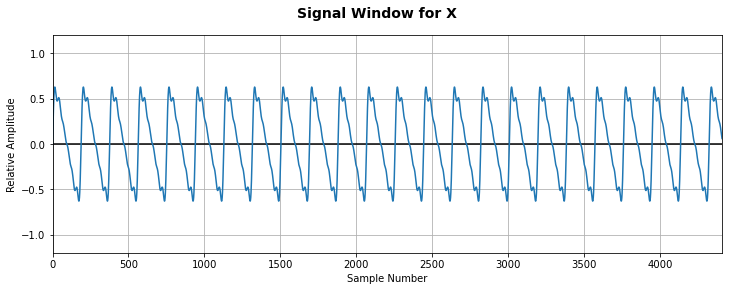

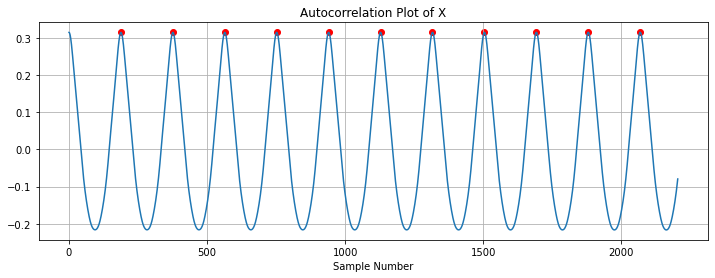

Detected Period:     188.08607576520532
Detected Freq:       234.46711735881837
Actual Period:       188.00527216235776
Actual Freq:         234.56789
Percent Error:       0.042961 %


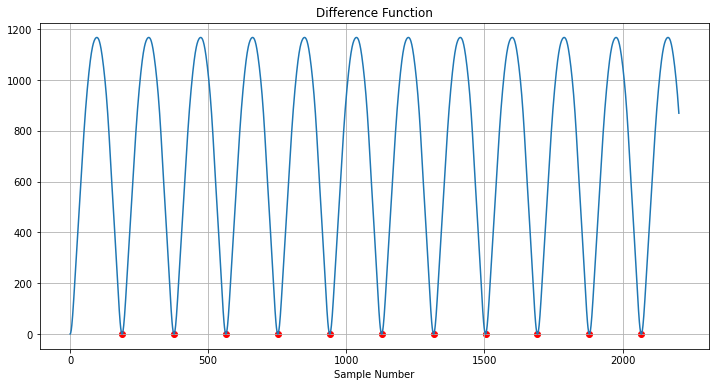

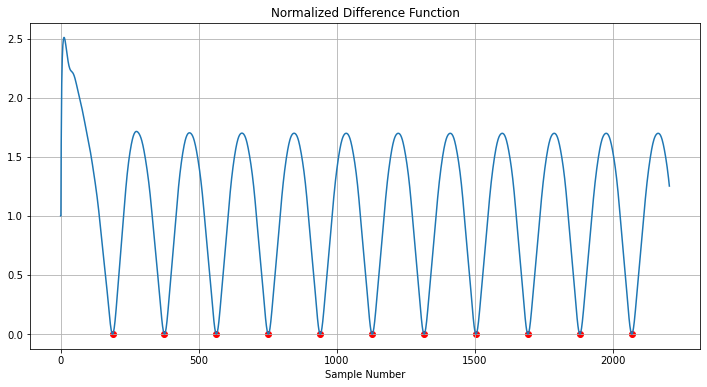

Yin Detected F0 (no interpolation):   234.5744680851064
Yin Detected F0 (with interpolation): 234.56965453306884
Actual Period:       188.00527216235776
Actual Freq:                          234.56789
Percent Error (no interp):   -0.002804 %
Percent Error (interp):      -0.000752 %


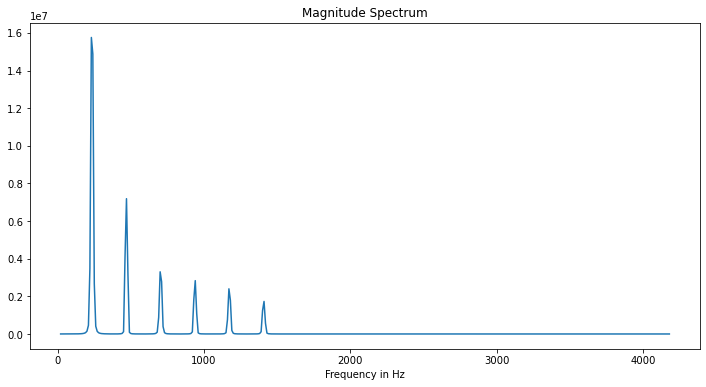

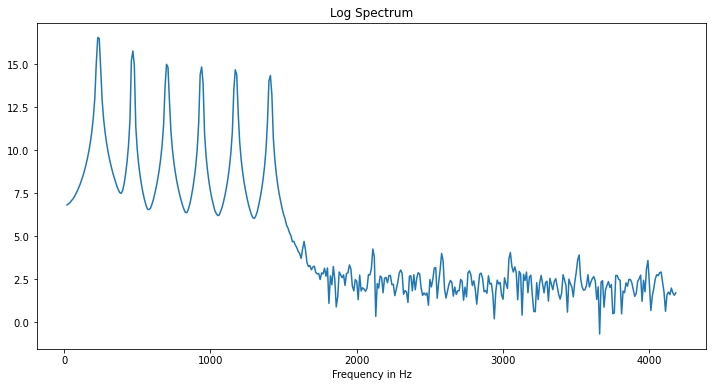

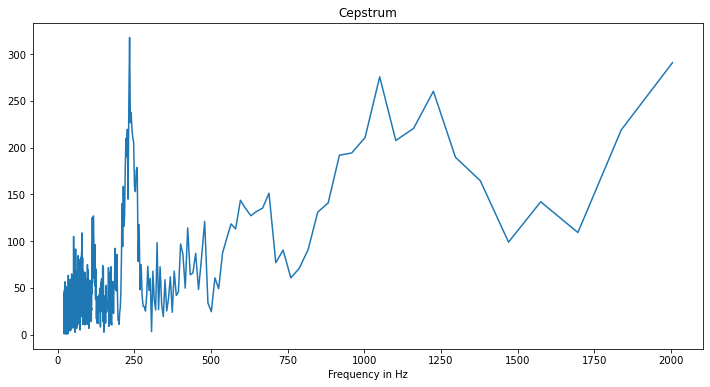

Peak at:  234.68085106382978 Hz.


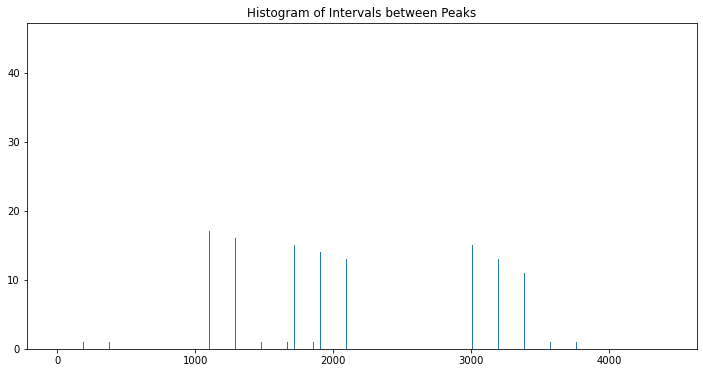

Peak at:  234.5744680851064 Hz.


In [97]:
# f_mC = Freqs['C4']

f_mC = 234.56789

X = makeSignal([(f_mC,0.5,0),(f_mC*2,0.2,0),(f_mC*3,0.1,0),(f_mC*4,0.08,0),(f_mC*5,0.07,0),(f_mC*6,0.05,0)])
displayAllMetrics(X,0.0,0.1,f_mC)

In [98]:
syntheticSampleLabels = [ (i, p) for i in instruments for p in FS]
syntheticSamples = [ scaleSignal(makeNote(i, pitch=p)) for i in instruments for p in FS]

print()
for k in range( len(syntheticSampleLabels) ):
    print(k, ":", syntheticSampleLabels[k])

NameError: name 'FS' is not defined

### Triangle Wave:  

WS:  Has only ODD harmonics, so cepstrum finds the distance between the odd harmonics, which is 2x as big as f0. 
Histogram works fine!

In [ ]:
n = 1
X = syntheticSamples[n]
print(syntheticSampleLabels[n])
displayAllMetrics(X,0.0,0.1,syntheticSampleLabels[n][1])

### Square Wave

WS:  Again, only odd harmonics, so cepstrum finds 2x too big, but histogram works fine. 

In [ ]:
n = 5
X = syntheticSamples[n]
print(syntheticSampleLabels[n])
displayAllMetrics(X,0.0,0.1,syntheticSampleLabels[n][1])

### Bell

WS:   Gabe suggested inharmonics create problem!  This doesn't work at all!

In [ ]:
n = 10
X = syntheticSamples[n]
print(syntheticSampleLabels[n])
displayAllMetrics(X,0.0,0.1,syntheticSampleLabels[n][1])

### Synthetic Organ

WS: Lots of missing harmonics at higher end, look at the spectrum, so cepstrum finds 2x as big, histogram doesn't
work at all. 

In [ ]:
n = 13
X = syntheticSamples[n]
print(syntheticSampleLabels[n])
displayAllMetrics(X,0.0,0.1,syntheticSampleLabels[n][1])

### Steel String

WS:  Has subharmonic. But works well if we cut off the cepstrum at some point. 

In [ ]:
n = 17
X = syntheticSamples[n]
print(syntheticSampleLabels[n])
displayAllMetrics(X,0.0,0.1,syntheticSampleLabels[n][1])

### Clarinet

WS:  Odd harmonics strike again!  But histogram works fine. 

In [ ]:
n = 21
X = syntheticSamples[n]
print(syntheticSampleLabels[n])
displayAllMetrics(X,0.0,0.1,syntheticSampleLabels[n][1])

### REAL SIGNALs

### Invention One

WS:  This one seems like it should be simple, one note on piano, but Yin doesn't get it.
Cepstrum and histogram work fine though. 

In [ ]:
X = readWaveFile(path+"invention.C4.wav")
displaySignal(X[int(SR*0.34):int(SR*0.39)]*20)

In [ ]:
displayAllMetrics(X,0.34,0.1,Freqs['C4'])

In [ ]:
for k in range( len(realSamples) ):
    print(k, ":", realSamples[k])

### Real clarinet

WS:  cepstrum works well. Not Yin

In [ ]:
f = Freqs['A4'] 
dur = 0.1
# for k in range(1,len(realSamples)):

k = 32
start = realSamples[k][1]
X = readWaveFile(path+realSamples[k][0])
Audio(X[int(SR*start):int(SR*(start+dur))],rate=SR) 

In [ ]:
print(k, "\t", realSamples[k][0], "\t", f)
displayAllMetrics(X,realSamples[k][1],dur,f)

   

In [ ]:
n = 21
X = syntheticSamples[n]
print(syntheticSampleLabels[n])
displayAllMetrics(X,0.0,0.1,syntheticSampleLabels[n][1])